In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))

batch = torch.stack(batch, dim=0)
print("Batch shape:", batch)
print("Batch shape:", batch.shape)

Batch shape: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Batch shape: torch.Size([2, 4])


In [4]:
from types import SimpleNamespace

GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

cfg = SimpleNamespace(**GPT_CONFIG_124M)

-------------
### 1.Architect

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        
        assert (d_out % num_heads == 0), \
              "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.proj_out = nn.Linear(d_out, d_out)

        self.drop = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), 
                       diagonal=1)
        )

    def forward(self,x):
        batch_size, num_token, d_in = x.shape
        queris = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queris = queris.view(batch_size, num_token, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, num_token, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_token, self.num_heads, self.head_dim)
        
        keys, queris, values = keys.transpose(1, 2), values.transpose(1, 2), values.transpose(1, 2)

        attn_score = queris @ keys.transpose(2, 3)

        num_tokens = attn_score.shape[-1]
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_score.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_score / self.head_dim ** 0.5, dim=-1
        )

        attn_weights_T = self.drop(attn_weights)

        context_vecs = (attn_weights_T @ values).transpose(1, 2) #Turn to previous shape
        context_vecs = context_vecs.contiguous().view(batch_size, num_token, self.d_out)

        context_vecs = self.proj_out(context_vecs)

        return context_vecs
      

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.eps = 1e-5

        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
                
        return self.scale * x_norm + self.shift


In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.layer = nn.Sequential(
            nn.Linear(cfg.emb_dim, cfg.emb_dim * 4),
            nn.GELU(),
            nn.Linear(cfg.emb_dim * 4, cfg.emb_dim)
        )

    def forward(self, x):
        return self.layer(x)

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.att = MultiHeadAttention(
            d_in=cfg.emb_dim,
            d_out=cfg.emb_dim,
            context_length=cfg.context_length,
            dropout=cfg.drop_rate,
            num_heads=cfg.n_heads,
            qkv_bias=cfg.qkv_bias
        )
        self.drop_shortcut = nn.Dropout(cfg.drop_rate)
        self.norm2 = LayerNorm(cfg.emb_dim)
        self.ff = FeedForward(cfg)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut  = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim, padding_idx=0)
        self.drop_emb = nn.Dropout(cfg.drop_rate)

        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )

        self.final_norm = LayerNorm(cfg.emb_dim)
        self.out_head = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
            
        tok_embds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
            
        return logits



In [10]:
torch.manual_seed(123)
model = GPTModel(cfg=cfg)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.0299,  0.4016, -0.1832,  ...,  0.2382,  0.1335, -0.0026],
         [-0.3660, -0.6070, -0.9522,  ...,  0.0185,  0.3878, -0.1475],
         [ 0.6360,  0.0491, -0.1021,  ...,  0.2388, -0.5530, -0.1340],
         [-1.0082,  0.6910, -0.2610,  ...,  0.9021,  0.3022,  0.0400]],

        [[ 0.3452,  0.7111,  0.2879,  ...,  0.5134, -0.0839, -0.1846],
         [ 0.0481,  0.4498, -0.0841,  ...,  1.0691,  0.0496,  0.5799],
         [ 0.9337,  1.0010, -0.0713,  ...,  0.6798, -0.0080,  0.0108],
         [-0.1759,  0.4921,  0.3420,  ...,  1.1668, -0.4244,  0.1454]]],
       grad_fn=<UnsafeViewBackward0>)


### End of Architect
--------------

### 2. Generating Text

In [11]:
torch.manual_seed(123)
model = GPTModel(cfg=cfg)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=0)
  (pos_emb): Embedding(1024, 768, padding_idx=0)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (proj_out): Linear(in_features=768, out_features=768, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)

        last_logits = logits[:, -1, :] # last_logits is the logits for the last token in the sequence
        probas = torch.softmax(last_logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [13]:
start_context = "I HAD always thought"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimensio
print("encoded_tensor.shape:", encoded_tensor.shape) # (1, seq_len)

encoded: [40, 367, 2885, 1464, 1807]
encoded_tensor.shape: torch.Size([1, 5])


In [14]:
model.eval() # Set the model to evaluation mode

out = generate_text_simple(
    model, idx=encoded_tensor,
    max_new_tokens=6,
    context_size=cfg.context_length
)

print("output:", out)
print("output Length", len(out[0]))

output: tensor([[   40,   367,  2885,  1464,  1807, 41117,  5824, 39347, 41341, 31192,
         12676]])
output Length 11


In [15]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

I HAD always thought discriminated94 phpprocessor fertileombies


In [16]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # allowed_special makes sure special tokens are handled correctly 
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # unsqueeze to add batch dimension
    
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Convert to 1D tensor and remove batch dimension
    return tokenizer.decode(flat.tolist()) # Convert to list for decoding

In [17]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model, 
    idx= text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg.context_length
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you Aeiman Byeswick lugDDcompl shotguntenance IR


In [18]:
inputs = torch.tensor([[16833, 3626, 6100],
 [40, 1107, 588]])

In [19]:
targets = torch.tensor([[3626, 6100, 345 ],
 [1107, 588, 11311]])

In [20]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)


torch.Size([2, 3, 50257])


In [21]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[ 5119],
         [15899],
         [20610]],

        [[23598],
         [49289],
         [24570]]])


In [22]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: ogue SpotFriday


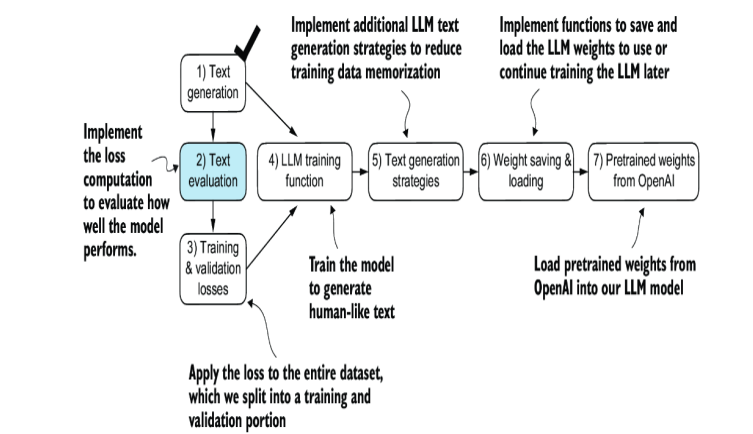

⸻

🧠 LLM Training Workflow & Evaluation Strategy

📌 Overview of the Training Pipeline

The diagram below summarizes the complete workflow for building and evaluating a Language Model (LLM):

1) Text Generation           🔄 Generate text using current model
2) Text Evaluation           📏 Compare output with target (ground truth)
3) Training & Validation     📉 Compute loss between prediction and target
4) Training Function         🔧 Update model weights via backpropagation
5) Text Generation Strategies🪄 Improve diversity & reduce memorization
6) Weight Saving & Loading   💾 Save model to resume training later
7) Pretrained Weights        📦 Use OpenAI pretrained weights to warm-start

👉 Each of these blocks represents a critical phase in the lifecycle of LLM development. This structured design helps balance generation quality, evaluation accuracy, and training efficiency.

⸻

🎯 Objective During Training

“The model training aims to increase the softmax probability in the index positions corresponding to the correct target token IDs.” — Sebastian Raschka

	•	After each forward pass, the model produces a logits tensor of shape [batch_size, seq_len, vocab_size].
	•	These logits are passed through a softmax layer, converting them to a probability distribution over the vocabulary.
	•	During training, we maximize the probability of the correct next token (target) by computing the cross-entropy loss between the predicted probability distribution and the actual token ID.
	•	This process encourages the model to generate outputs that match the ground truth tokens as closely as possible.

⸻

✅ Evaluation Metric

We use the softmax score at the target token position as a numerical measure of how confident the model is in its prediction.

💡 “The higher the probability assigned to the correct token, the better.”

This probability also forms the basis for computing perplexity, a common metric for evaluating language models.

In [23]:
text_idx = 1
# [:, -1] to get the last token in each sequence and flatten the tensor
target_text = targets[:, -1]
print(target_text)

# [:, -1:] to get the last token in each sequence and keep the batch dimension
target_text = targets[:, -1:]
print("Target text:", target_text)

tensor([  345, 11311])
Target text: tensor([[  345],
        [11311]])


⸻


## 🔄 Python List Comprehension Cheatsheet

Python list comprehension provides a concise way to create lists. The general syntax is:

```python
[expression for item in iterable if condition]

🔁 Equivalent to a standard for-loop:

# Traditional way
squares = []
for x in range(5):
    squares.append(x ** 2)

# List comprehension version
squares = [x ** 2 for x in range(5)]


⸻

✅ Use Case in Our GPT Project

We want to extract the predicted probabilities (from probas) for the correct target token in each row.

❌ Incorrect attempt:

target_probas_2 = [
    target_probas_1 = probas[count, [0, 1, 2], targets[count]]
    for count in range(len(targets))
]

This throws a SyntaxError because assignment (=) is not allowed inside list comprehensions.

⸻

✅ Correct version:

target_probas_2 = [
    probas[count, [0, 1, 2], targets[count]]
    for count in range(len(targets))
]

This creates a list of probabilities for each item in targets using clean list comprehension.

⸻

💡 Tip
	•	List comprehensions must contain an expression only, not a statement like assignment.
	•	For more complex logic (e.g. multiple lines), use a regular for loop instead.

---

In [24]:
for count in range(len(targets)):
    text_idx = count
    # Get the probabilities for the target tokens in the current text index
    target_probas_1 = probas[text_idx, [0, 1, 2], targets[count]]
    print(target_probas_1)


target_probas_2 = [
    probas[count, [0, 1, 2], targets[count]]  for count in range(len(targets))
                   ]
print("Target probabilities for each text index:", target_probas_2)


tensor([2.7392e-05, 1.7369e-05, 1.2872e-05])
tensor([2.9864e-05, 1.5725e-05, 1.0762e-05])
Target probabilities for each text index: [tensor([2.7392e-05, 1.7369e-05, 1.2872e-05]), tensor([2.9864e-05, 1.5725e-05, 1.0762e-05])]


In [25]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(target_probas_2)


tensor([2.7392e-05, 1.7369e-05, 1.2872e-05])
tensor([2.9864e-05, 1.5725e-05, 1.0762e-05])


## 📉 Why We Use log() for Probabilities in Language Modeling

When dealing with very small probabilities (e.g., 1e-5), multiplying them directly can quickly lead to *underflow*, making the values too small for floating point precision.

### 💡 Solution: Use Log Probabilities

Instead of multiplying:

$$
P_{\text{total}} = p_1 \times p_2 \times p_3 \times \dots
$$

We compute:

$$
\log(P_{\text{total}}) = \log(p_1) + \log(p_2) + \log(p_3) + \dots
$$

### ✅ Benefits of Using Log Probabilities:
- Prevents *numerical underflow* when chaining many probabilities.
- Converts *multiplication into addition*, which is computationally more stable.
- Required for loss functions like *Negative Log Likelihood (NLL)* and *Cross-Entropy Loss*, which are based on log probabilities.

---

### 🔢 Example (Python code):
```python
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

In [26]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.5053, -10.9608, -11.2604, -10.4189, -11.0602, -11.4395])


In [27]:
# ___avg_log_probas = torch.mean(log_probas) use because it is the average of the log probabilities of the target tokens across all texts in the batch
# ___This gives a single value that represents the average log probability of the target tokens.
# ___It uses to calculate the average log probability of the target tokens across all texts in the batch.
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.9409)


In [28]:
# ___if avg_log_probas <= 0  then we take the negative of the average log probabilities
# ___This is because log probabilities can be negative, and we want to ensure that the final value is non-negative.
# ___If avg_log_probas is positive, we keep it as is.
if avg_log_probas <= 0 :
    neg_avg_log_probas = avg_log_probas * -1
    print(neg_avg_log_probas)
else:
    print(avg_log_probas)

tensor(10.9409)


In [29]:
# Print the shapes of logits and targets because they are important for debugging 
# and understanding the model's output
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [30]:
# Flatten the logits tensor to prepare for further processing
# This is useful for calculating probabilities or loss functions that require a 1D tensor.
logits_flat = logits.flatten(start_dim=0, end_dim=1)
target_flat = targets.flatten(start_dim=0, end_dim=1)

print("Logits flat shape:", logits_flat.shape)
print("Targets flat shape:", target_flat.shape)


Logits flat shape: torch.Size([6, 50257])
Targets flat shape: torch.Size([6])


In [31]:
loss = torch.nn.functional.cross_entropy(
    logits_flat, 
    target_flat, 
    ignore_index=0  # Ignore padding index and make sure it does not affect the loss calculation
)
# deference between loss.item() and loss :
# loss.item() returns a Python number, while loss is a tensor.
print("Loss:\n", loss.item())
print("Loss :\n", loss)

Loss:
 10.940853118896484
Loss :
 tensor(10.9409)


⸻


## 🤯 What is Perplexity in Language Modeling?

*Perplexity* is a commonly used evaluation metric in language models, often used alongside *cross-entropy loss. It provides an interpretable way to assess the **uncertainty* of a model when predicting the next token in a sequence.

---

### 📏 How Does Perplexity Work?

- Perplexity measures *how well the predicted probability distribution* matches the true distribution of words in the dataset.
- A *lower perplexity* indicates that the model is more confident and accurate in its predictions.
- A *higher perplexity* suggests that the model is more "confused" about which token comes next.

---

### 🔍 Why Perplexity is Useful

- Unlike raw loss values, perplexity gives you an idea of the *effective vocabulary size* the model is uncertain about at each prediction step.
- For example:
  
  If the model has a perplexity of 48725.82 (as in the image), that means it is roughly as uncertain as *randomly picking from 48,725 tokens* — which is the full vocabulary size!

---

### 📐 Formula

Given the *average loss* across tokens:

$$
\text{Perplexity} = \exp(\text{loss})
$$

---

### ✅ Interpretation

- Perplexity = 1 → perfect confidence (ideal case)
- Perplexity = |V| (vocabulary size) → completely uniform prediction (worst case)
- Lower perplexity = better language model

---

### 🧪 Example (PyTorch):

```python
perplexity = torch.exp(loss)
print(perplexity)

This converts your final cross-entropy loss into a meaningful perplexity value

In [32]:
perplexity = torch.exp(loss)
print("Perplexity:", perplexity.item())

Perplexity: 56435.46875


### 5.1.3 Calculating the training and validation set losses

In [33]:
file_path = "C:/Users/Taha/OneDrive/Desktop/LLM/Book/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

In [34]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [35]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [36]:
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        super().__init__()
        
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        length = len(token_ids)
        
        for i in range(0, len(token_ids) - max_length - 1, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + 1 + max_length]

            if len(input_chunk) == max_length and len(target_chunk) == max_length:
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))
                

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [37]:
def create_dataloader_v1(
        txt:str, 
        batch_size:int, 
        max_length:int, 
        stride: int, 
        shuffle: bool, 
        drop_last: bool, 
        num_workers: int
):
     dataset = GPTDataset(
          txt = txt,
          tokenizer=tokenizer,
          max_length=max_length,
          stride=stride
     )

     dataloader = DataLoader(
          dataset=dataset,
          batch_size=batch_size,
          shuffle=shuffle,
          drop_last=drop_last,
          num_workers=num_workers
     )

     return dataloader

In [38]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=256,
    stride=256,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=256,
    stride=256,
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [39]:
print("Train loader:")
for inputs, targets in train_loader:
 print(inputs.shape, targets.shape)
print("\nValidation loader:")
for inputs, targets in val_loader:
 print(inputs.shape, targets.shape)


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )

    return loss

In [41]:
# Calculate the loss for a DataLoader
# This function iterates over the DataLoader and computes the total loss for the dataset.
# data_loader: The DataLoader containing the dataset like train_loader or val_loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    num_batches = len(data_loader)

    if num_batches == 0:
        return float('nan')

    for input_batch, target_batch in data_loader:
        loss = calc_loss_batch(input_batch, target_batch, model, device) # Calculate loss for the batch
        total_loss += loss.item() # Accumulate the loss for each batch

    return total_loss / num_batches # Average loss per batch

In [42]:
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.990754869249132
Validation loss: 10.993842124938965


### Training an LLM :


In [43]:
def train_model_simple(model, train_loader, val_loader, 
                       optimizer, device, num_epochs,
                       eval_iter, eval_freq, start_context, tokenizer):
    #eval_freq: Frequency of evaluation on the validation set,*|>
    # *|> it is used to determine how often the model should be evaluated during training.
    #eval_iter: Number of iterations to evaluate the model

    # track_tokens_seen  is a list that will keep track of the number of tokens seen during training
    # It is initialized as an empty list at the beginning of the training process.
    # global_step: A counter that keeps track of the number of training steps taken so far.
    # token_seen: A counter that keeps track of the number of tokens seen during training.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            
            #input_batch.numel() returns the total number of elements in the input batch tensor
            #.numel() is a method that returns the total number of elements in a tensor.
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
                
        generate_and_print_Sample(
            model, tokenizer, device, start_context
            )


    return train_losses, val_losses, track_tokens_seen

In [44]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches = eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches = eval_iter
        )
        model.train()
        return train_loss, val_loss

In [45]:
def generate_and_print_Sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model, idx = encoded, 
            max_new_tokens=10, context_size=context_size
            )
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()


In [46]:
torch.manual_seed(123)
model = GPTModel(cfg=cfg)
model.to(device)
optimizer = torch.optim.AdamW(
 model.parameters(),
 lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="I love you ", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.907, Val loss 10.019
Ep 1 (Step 000005): Train loss 8.125, Val loss 8.378
I love you .         
Ep 2 (Step 000010): Train loss 6.695, Val loss 7.038
Ep 2 (Step 000015): Train loss 6.063, Val loss 6.621
I love you , and I.      
Ep 3 (Step 000020): Train loss 5.550, Val loss 6.504
Ep 3 (Step 000025): Train loss 5.423, Val loss 6.363
I love you  of the Gisburn. Gisburn--
Ep 4 (Step 000030): Train loss 5.054, Val loss 6.351
Ep 4 (Step 000035): Train loss 4.553, Val loss 6.347
I love you  hisburn's. "I had been to
Ep 5 (Step 000040): Train loss 4.154, Val loss 6.230
I love you  I felt it--I had been.  
Ep 6 (Step 000045): Train loss 3.733, Val loss 6.178
Ep 6 (Step 000050): Train loss 3.262, Val loss 6.208
I love you  I felt it.      
Ep 7 (Step 000055): Train loss 2.840, Val loss 6.169
Ep 7 (Step 000060): Train loss 2.414, Val loss 6.215
I love you  I felt it was a little the fact--his
Ep 8 (Step 000065): Train loss 2.017, Val loss 6.255
Ep 8 (Step 000070)

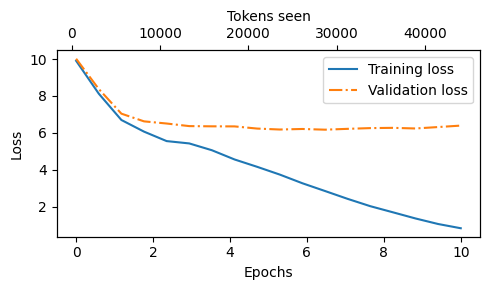

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() #1
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Temperature scaling


In [48]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}
print(inverse_vocab)

{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [49]:
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [50]:
probas = torch.softmax(next_token_logits, dim=0)
print(probas)
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])


tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [51]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(next_token_id)

3


In [52]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)    
    sample = []
    for i in range(10000):
        sample.append(torch.multinomial(probas, num_samples=1).item())

    # .bincount means counting the occurrences of each token ID in the sample
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

664 x closer
11 x every
0 x effort
5718 x forward
32 x inches
0 x moves
1 x pizza
3536 x toward
38 x you


In [53]:
def softmax_with_temperature(logits, temperature):
    scale_logits = logits / temperature
    print(scale_logits)
    return torch.softmax(scale_logits, dim=0)

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
tensor([ 45.1000,   8.9000, -19.0000,  67.5000,  16.3000, -16.2000, -18.9000,
         62.8000,  17.9000])
tensor([ 0.9020,  0.1780, -0.3800,  1.3500,  0.3260, -0.3240, -0.3780,  1.2560,
         0.3580])


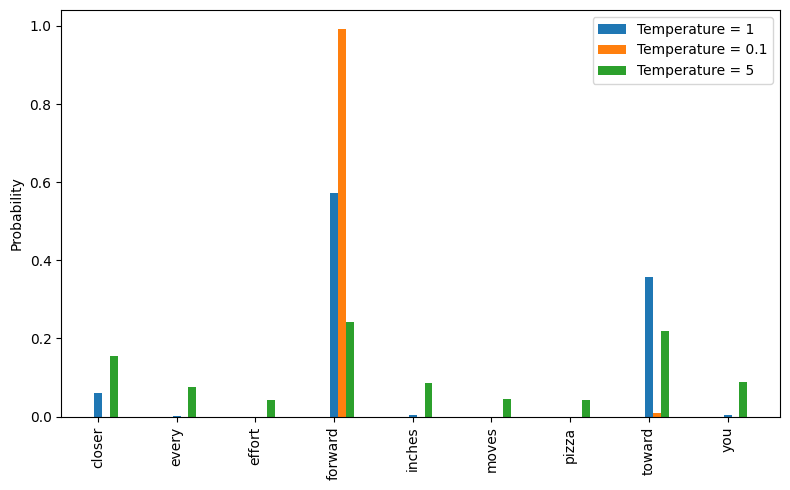

In [54]:
temperature = [1, 0.1, 5]
scaled_probas = [
    softmax_with_temperature(next_token_logits, T ) for T in temperature
]
x = torch.arange(len(vocab))

bar_width = 0.1
fig, ax = plt.subplots(figsize=(8, 5))
for i, T in enumerate(temperature):
 rects = ax.bar(x + i * bar_width, scaled_probas[i],
 bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [55]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top Logits :", top_logits)
print("Top positions :", top_pos)

Top Logits : tensor([6.7500, 6.2800, 4.5100])
Top positions : tensor([3, 7, 0])


In [56]:
new_logits = torch.where(
    # top_logits[-1] is the smallest of the top k logits and means that *|>
    # *|> we only keep the logits that are greater than or equal to the smallest of the top k logits
    condition = next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other = next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [57]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [58]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )

            if temperature >0.0:
                logits = logits / temperature
                probs = torch.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.softmax(
                    logits, dim=-1, keepdim=True
                )
            if idx_next == eos_id:
                break
            idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [59]:
torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
 max_new_tokens=15,
 context_size = cfg.context_length,
 top_k=20,
 temperature=0.1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
"Oh a little too? I--I told me.



### Loading and saving model weights in PyTorch


In [60]:
# torch.save(model.state_dict(), "model.path")

In [61]:
# model = GPTModel(cfg)
# model.load_state_dict(torch.load("model.path", map_location=device))
# model.eval()

In [62]:
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 },
 "model_and_optimizer.pth"
)

In [63]:
# Load the model and optimizer state dictionaries
# This code loads the model and optimizer state dictionaries from a file named "model_and_optimizer.pth".
# It uses torch.load to load the checkpoint and map the tensors to the appropriate device.
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(cfg)
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [64]:
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="I love you ", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 0.626, Val loss 6.396
Ep 1 (Step 000005): Train loss 0.502, Val loss 6.460
I love you  thought Jack Gisburn rather a cheap genius--
Ep 2 (Step 000010): Train loss 0.380, Val loss 6.557
Ep 2 (Step 000015): Train loss 0.301, Val loss 6.617
I love you  thought Jack Gisburn rather a cheap genius--
Ep 3 (Step 000020): Train loss 0.231, Val loss 6.615
Ep 3 (Step 000025): Train loss 0.198, Val loss 6.720
I love you  thought Jack Gisburn rather a cheap genius--
Ep 4 (Step 000030): Train loss 0.190, Val loss 6.858
Ep 4 (Step 000035): Train loss 0.189, Val loss 6.824
I love you  thought Jack Gisburn rather a cheap genius--
Ep 5 (Step 000040): Train loss 0.153, Val loss 6.904
I love you  thought Jack Gisburn rather a cheap genius--
Ep 6 (Step 000045): Train loss 0.119, Val loss 6.909
Ep 6 (Step 000050): Train loss 0.115, Val loss 6.936
I love you  thought Jack Gisburn rather a cheap genius--
Ep 7 (Step 000055): Train loss 0.100, Val loss 6.956
Ep 7 (Step 000060): Tr

In [65]:
torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
 max_new_tokens=15,
 context_size = cfg.context_length,
 top_k=20,
 temperature=0.1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted


### Loading pretrained weights from OpenAI


In [67]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)


('gpt_download.py', <http.client.HTTPMessage at 0x22acb84aa20>)

In [68]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
 model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 76.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 877kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 90.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:34<00:00, 3.22MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.21MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 448kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 424kiB/s] 


In [69]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [71]:
print(params['wte'])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [72]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


In [76]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [77]:
NEW_CONFIG.update({"context_length": 1024})

In [78]:
NEW_CONFIG.update({"qkv_bias": True})

In [80]:
cfg = SimpleNamespace(**NEW_CONFIG)

In [82]:
gpt = GPTModel(cfg)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768, padding_idx=0)
  (pos_emb): Embedding(1024, 768, padding_idx=0)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (proj_out): Linear(in_features=768, out_features=768, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
  

In [85]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}"
        )
    
    return torch.nn.Parameter(torch.tensor(right))